# Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

## Домашнее задание

1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. Сделать обзорный анализ выбранного датасета
3. Обучить любой классификатор (какой вам нравится)
4.  разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для 5 случайных объектов из тестового набора

In [ ]:
 # !./bash/hw7.sh

In [16]:
# for colab use only
from google.colab import drive
import os

drive.mount('/content/drive/')
root_path = '/content/drive/MyDrive/learning/geekbrains/4_business_ML/hws'
os.chdir(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [66]:
import shap
import pandas as pd
from catboost import CatBoostClassifier
from IPython.display import Image


from lib.reports import PrecisionReport


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [20]:
df = pd.read_csv("data/churn_data.csv")
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4191,4192,15715597,Onyemauchechi,679,France,Male,36,1,97234.58,1,1,0,188997.08,0
4716,4717,15805764,Hallahan,646,France,Male,18,10,0.00,2,0,1,52795.15,0
6970,6971,15761286,Fan,696,Germany,Female,66,7,119499.42,2,1,1,174027.30,0
5960,5961,15728917,Gill,598,France,Male,48,6,120682.53,1,1,0,30635.52,1
7204,7205,15585192,Cremonesi,686,Spain,Male,39,10,136258.06,1,0,0,89199.51,0


In [21]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Exited']), df['Exited'], random_state=0)

cat_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
cont_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

X_train = X_train[cat_columns + cont_columns]
X_test = X_test[cat_columns + cont_columns]

In [23]:
model = CatBoostClassifier(random_state=42, n_estimators=50, cat_features=cat_columns)
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]
PrecisionReport(y_test, preds).report()

Learning rate set to 0.379865
0:	learn: 0.5319127	total: 53.9ms	remaining: 2.64s
1:	learn: 0.4578775	total: 58ms	remaining: 1.39s
2:	learn: 0.4126827	total: 62.4ms	remaining: 978ms
3:	learn: 0.3909836	total: 66.8ms	remaining: 768ms
4:	learn: 0.3684082	total: 71.2ms	remaining: 641ms
5:	learn: 0.3570666	total: 77.3ms	remaining: 567ms
6:	learn: 0.3513283	total: 82.3ms	remaining: 506ms
7:	learn: 0.3439702	total: 87.3ms	remaining: 458ms
8:	learn: 0.3412511	total: 91.6ms	remaining: 417ms
9:	learn: 0.3385701	total: 96ms	remaining: 384ms
10:	learn: 0.3359899	total: 100ms	remaining: 355ms
11:	learn: 0.3348524	total: 104ms	remaining: 330ms
12:	learn: 0.3309841	total: 109ms	remaining: 309ms
13:	learn: 0.3299536	total: 113ms	remaining: 290ms
14:	learn: 0.3288445	total: 117ms	remaining: 273ms
15:	learn: 0.3272417	total: 121ms	remaining: 257ms
16:	learn: 0.3252724	total: 125ms	remaining: 243ms
17:	learn: 0.3238494	total: 130ms	remaining: 231ms
18:	learn: 0.3235009	total: 134ms	remaining: 219ms
19:	l

{'F-Score': 0.6510204081632652,
 'Precision': 0.6772823779193206,
 'ROC AUC': 0.8803732710754387,
 'Recall': 0.6267190569744597,
 'model': None,
 'thresh': 0.39598748149750623}

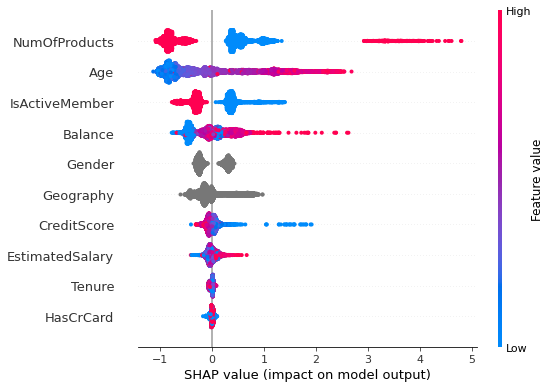

In [24]:
explainer = shap.TreeExplainer(model)
preds_train = model.predict_proba(X_train)[:, 1]
shap_values_all = explainer.shap_values(X_train)
features = cat_columns + cont_columns
shap.summary_plot(shap_values_all, X_train, feature_names=features)

In [26]:
shap.initjs()
idx = 1
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, 
                shap_values_all[idx,:], 
                features=X_train.iloc[idx,:], 
                feature_names=features)

pred is 0.026633163401453986


In [27]:
shap.initjs()
idx = 200
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, 
                shap_values_all[idx,:], 
                features=X_train.iloc[idx,:], 
                feature_names=features)

pred is 0.13239510676532326


In [ ]:
# for idx in range(len(df.index)):
for idx in range(0,len(df.index), 500):
  
  full_file_name = f'hw7_pictures/{idx} - pred is {preds_train[idx]}.png'
  shap.force_plot(explainer.expected_value, 
                shap_values_all[idx,:], 
                features=X_train.iloc[idx,:], 
                feature_names=features, 
                show=False,
                matplotlib=True).savefig(full_file_name)

In [62]:
@interact 
def show_images(file=os.listdir('hw7_pictures/')): 
  display(Image(file))

interactive(children=(Dropdown(description='file', options=('0 - pred is 0.9490031923757738.png', '1 - pred is…